In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import pandas as pd

Predicting winning 2025 Baseball Team
- 
Note: We compiled data from https://retrosheet.org/downloads/csvdownloads.html. 

### Hypothesis
Given two teams statistics and date they played, we can predict who won that specific match. <br><br>
Alternative hypotheses could be if weather, time of day effect, location of playing affect a teams outcome. Following, we can also see if any interal statistics of a team such as batter appearances or stolen bases influence a match's outcome or not. 

Limitations of our model: It cannot predict winners in early games due to a lack of data around that time. Although we can incoporate data from last year, many other factors such as team swaps and new playing strategies can affect data from season to season may from this.

In [23]:
gameInfo = pd.read_csv("data/2025gameinfo.csv")
teamStats = pd.read_csv("data/2025teamstats.csv")

In [24]:
gameInfo.head()

,gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,...,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season
0,CHN202503180,LAN,CHN,TOK01,20250318,0,7:10PM,night,9,2.0,...,4,1,LAN,CHN,y,both,y,y,y,2025
1,CHN202503190,LAN,CHN,TOK01,20250319,0,7:10PM,night,9,2.0,...,6,3,LAN,CHN,y,both,y,y,y,2025
2,ARI202503270,CHN,ARI,PHO01,20250327,0,7:10PM,night,9,2.0,...,10,6,CHN,ARI,y,both,y,y,y,2025
3,CHA202503270,ANA,CHA,CHI12,20250327,0,3:10PM,day,9,2.0,...,1,8,CHA,ANA,y,both,y,y,y,2025
4,CIN202503270,SFN,CIN,CIN09,20250327,0,4:10PM,day,9,2.0,...,6,4,SFN,CIN,y,both,y,y,y,2025


In [25]:
teamStats.head()

,gid,team,inn1,inn2,inn3,inn4,inn5,inn6,inn7,inn8,...,number,site,vishome,opp,win,loss,tie,gametype,box,pbp
0,CHN202503180,LAN,0,0,0,0,3,0.0,0.0,0.0,...,0,TOK01,v,CHN,1,0,0,regular,y,y
1,CHN202503180,CHN,0,1,0,0,0,0.0,0.0,0.0,...,0,TOK01,h,LAN,0,1,0,regular,y,y
2,CHN202503190,LAN,0,2,1,2,1,0.0,0.0,0.0,...,0,TOK01,v,CHN,1,0,0,regular,y,y
3,CHN202503190,CHN,0,0,1,1,1,0.0,0.0,0.0,...,0,TOK01,h,LAN,0,1,0,regular,y,y
4,ARI202503270,CHN,0,3,0,1,3,1.0,0.0,0.0,...,0,PHO01,v,ARI,1,0,0,regular,y,y


To preprocess our data, we are only concerned on the following gametypes: Regular, Wild Card, Divison Series, Leagure Champion Series, and World Series. We want to omit Allstars game. 

In [27]:
# drop all stars
teamStats = teamStats.drop(teamStats[teamStats['gametype'] == 'allstar'].index)
teamStats.head()

,gid,team,inn1,inn2,inn3,inn4,inn5,inn6,inn7,inn8,...,number,site,vishome,opp,win,loss,tie,gametype,box,pbp
0,CHN202503180,LAN,0,0,0,0,3,0.0,0.0,0.0,...,0,TOK01,v,CHN,1,0,0,regular,y,y
1,CHN202503180,CHN,0,1,0,0,0,0.0,0.0,0.0,...,0,TOK01,h,LAN,0,1,0,regular,y,y
2,CHN202503190,LAN,0,2,1,2,1,0.0,0.0,0.0,...,0,TOK01,v,CHN,1,0,0,regular,y,y
3,CHN202503190,CHN,0,0,1,1,1,0.0,0.0,0.0,...,0,TOK01,h,LAN,0,1,0,regular,y,y
4,ARI202503270,CHN,0,3,0,1,3,1.0,0.0,0.0,...,0,PHO01,v,ARI,1,0,0,regular,y,y


Now we want to preprocess our data. List of features we want to extract, create, and make are: finding team statistics leading up to game point and truncating win/loss/tie into one column of a Y output.

Here is a key to all the features we are going to be finding:
- 
- b_pa: plate appearances
- b_ab: At bats
- b_r: Runs scored
- b_h: Hits
- b_d: Doubles
- b_t: Triples
- b_hr: Home runs
- b_rbi: Runs batted in
- b_sh: Sacrifice hits
- b_sf: Sacrifice flies
- b_hbp: Hit by pitch
- b_w: Walks
- b_iw: Intentional walks
- b_k: Strikeouts
- b_sb: Stolen bases
- b_cs: Caught stealing
- b_gdp: Grounded into double play
- p_ipouts: Outs recorded (3 per inning)
- p_noout: ?? (likely no outs recorded in an appearance)
- p_bfp: Batters faced
- p_h: Hits allowed
- p_d: Doubles allowed
- p_t: Triples allowed
- p_hr: Home runs allowed
- p_r: Runs allowed
- p_er: Earned runs allowed
- p_w: Walks allowed
- p_iw: Intentional walks allowed
- p_k: Strikeouts
- p_hbp: Hit batters
- p_wp: Wild pitches
- p_bk: Balks
- p_sh: Sacrifice hits allowed
- p_sf: Sacrifice flies allowed
- p_sb: Stolen bases allowed
- p_cs: Runners caught stealing
- p_pb: Passed balls (catcher stat)
- d_po: Putouts
- d_a: Assists
- d_e: Errors
- d_dp: Double plays turned
- d_tp: Triple plays turned
- d_pb: Passed balls
- d_wp: Wild pitches (catcher perspective)
- d_sb: Stolen bases allowed (catcher)
- d_cs: Runners caught stealing (catcher)

In [28]:
# helper function
def findFeatures(key_features, row):
    teamLeadingStats = teamStats.loc[((teamStats['date'] < row['date']) & (teamStats['team'] == row['team']))]
    teamFeatures = dict.fromkeys(key_features)

    for feature in key_features:
        feature_total_sum = 0
        count = 0

        for _, row1 in teamLeadingStats.iterrows():
            count += 1
            feature_total_sum += row1[feature]

        if(count == 0):
            teamFeatures[feature] = 0
        else:
            teamFeatures[feature] = (feature_total_sum / count)
    
    return teamFeatures

In [30]:
key_features = ['b_pa', 'b_ab', 'b_r', 'b_h', 'b_d', 'b_t', 'b_hr', 'b_w', 'b_k', 'b_sb' , 'b_gdp', 'p_bfp', 'p_h', 'p_d', 'p_t', 'p_hr', 'p_r', 'p_w', 'p_k', 'p_hbp', 'p_sb', 'p_cs', 'd_a', 'd_dp', 'd_tp', 'd_sb']
polished_teamStats_df = pd.DataFrame(columns=['date', 'team'] + key_features)

for gameId in gameInfo['gid']:
    teams = teamStats.loc[(teamStats['gid'] == gameId)]

    for _, row in teams.iterrows():
        teamFeatures = findFeatures(key_features, row)
        teamFeatures['date'] = row['date']
        teamFeatures['team'] = row['team']

        polished_teamStats_df.loc[len(polished_teamStats_df)] = teamFeatures

polished_teamStats_df.head()

,date,team,b_pa,b_ab,b_r,b_h,b_d,b_t,b_hr,b_w,...,p_r,p_w,p_k,p_hbp,p_sb,p_cs,d_a,d_dp,d_tp,d_sb
0,20250318,LAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20250318,CHN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20250319,LAN,42.0,34.0,4.0,7.0,2.0,0.0,0.0,8.0,...,1.0,1.0,9.0,1.0,1.0,0.0,8.0,0.0,0.0,1.0
3,20250319,CHN,32.0,30.0,1.0,3.0,1.0,0.0,0.0,1.0,...,4.0,8.0,9.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
4,20250327,CHN,36.5,32.0,2.0,5.5,1.5,0.0,0.0,4.0,...,5.0,7.5,9.0,0.0,0.0,0.0,10.5,1.5,0.0,0.0


In [ ]:
# write to CSV
polished_teamStats_df["win"] = teamStats["win"]
polished_teamStats_df.to_csv('polished_teamStats.csv', index=False)

0       1.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
4949    0.0
4950    1.0
4951    0.0
4952    1.0
4953    0.0
Name: win, Length: 4954, dtype: float64


Plotting Data:<br>
We want to visualize the number of runs versus number of outs.

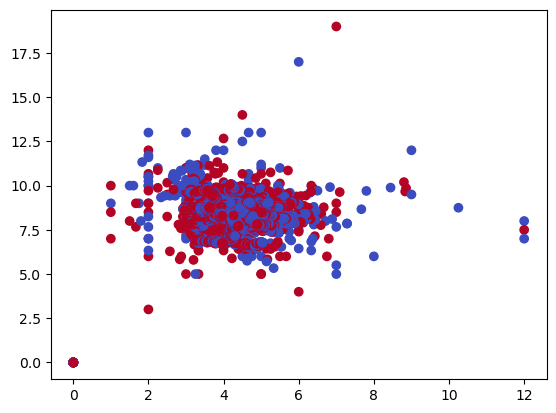

In [39]:
plt.scatter(x = polished_teamStats_df["b_r"].values, y = polished_teamStats_df["b_k"], c = polished_teamStats_df["win"].values, cmap='coolwarm')
plt.show()

In [ ]:
# Two Box and Whiskers: Wins/ Losses. Show that the average number of runs and compare if the median is bigger than another team.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(gameInfo[["visteam","hometeam","date"]],gameInfo["wteam"])
